In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each


In [4]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


<All keys matched successfully>

In [5]:
print(len(data_te[0]))
print(len(data_te[1]))
print(len(data_te[2]))

40000
40000
40000


In [6]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 1251/1250 | loss 1.3762 | val loss 1.3762 | acc 0.5908 | f1 0.4043 | prec 0.2958 | recall 0.6387 | roc auc 0.6737 | pr auc 0.4916 | elapsed 16.08s
train epoch 01/10 | batch 1251/1250 | loss 1.1162 | val loss 0.8434 | acc 0.7027 | f1 0.4897 | prec 0.3906 | recall 0.6559 | roc auc 0.7563 | pr auc 0.5832 | elapsed 36.34s
train epoch 02/10 | batch 1251/1250 | loss 0.6861 | val loss 0.5182 | acc 0.8030 | f1 0.6019 | prec 0.5368 | recall 0.6850 | roc auc 0.8329 | pr auc 0.6953 | elapsed 33.61s
train epoch 03/10 | batch 1251/1250 | loss 0.4375 | val loss 0.3438 | acc 0.8720 | f1 0.7078 | prec 0.7025 | recall 0.7131 | roc auc 0.8880 | pr auc 0.7973 | elapsed 35.38s
train epoch 04/10 | batch 1251/1250 | loss 0.3070 | val loss 0.2540 | acc 0.9100 | f1 0.7816 | prec 0.8270 | recall 0.7409 | roc auc 0.9226 | pr auc 0.8629 | elapsed 32.64s
train epoch 05/10 | batch 1251/1250 | loss 0.2379 | val loss 0.2040 | acc 0.9297 | f1 0.8250 | prec 0.8999 | recall 0.

In [7]:
with T.no_grad():
    idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

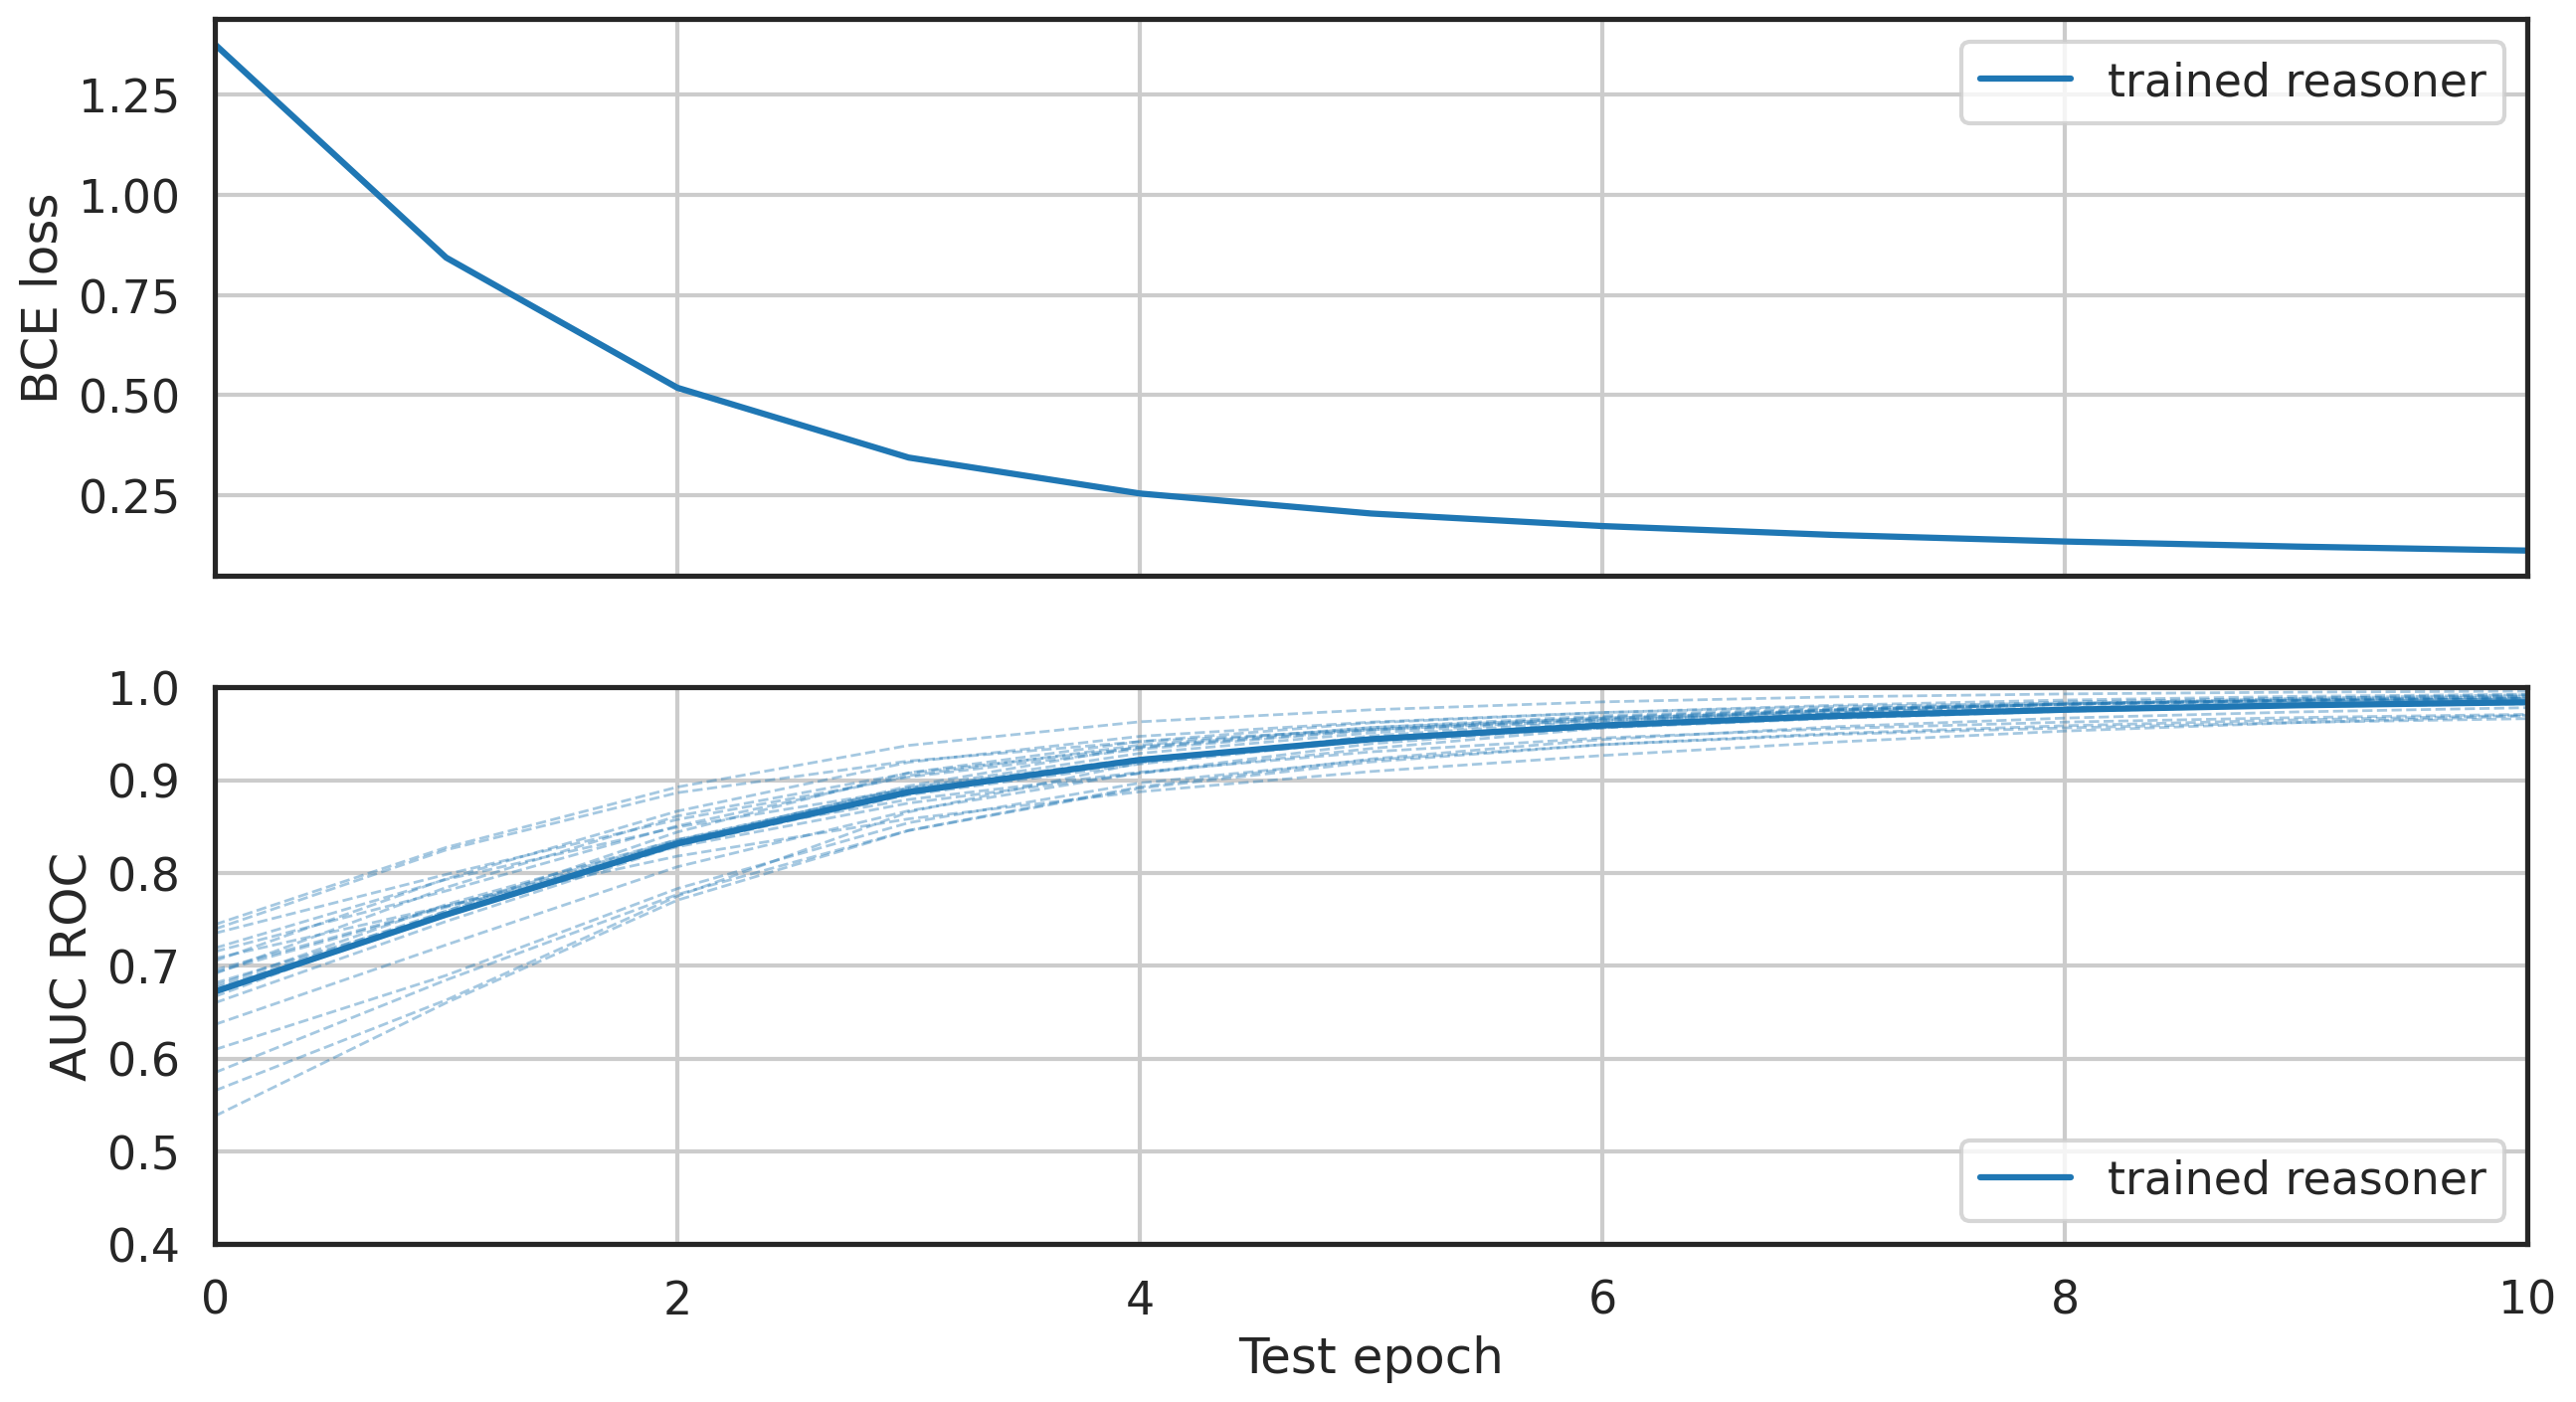

             mean       std     micro
acc      0.961075  0.014886  0.961075
prec     0.969063  0.024949  0.968992
recall   0.846996  0.044665  0.848091
f1       0.903647  0.034671  0.904520
auc_roc  0.983833  0.008646  0.984915
auc_pr   0.964273  0.018430  0.966513


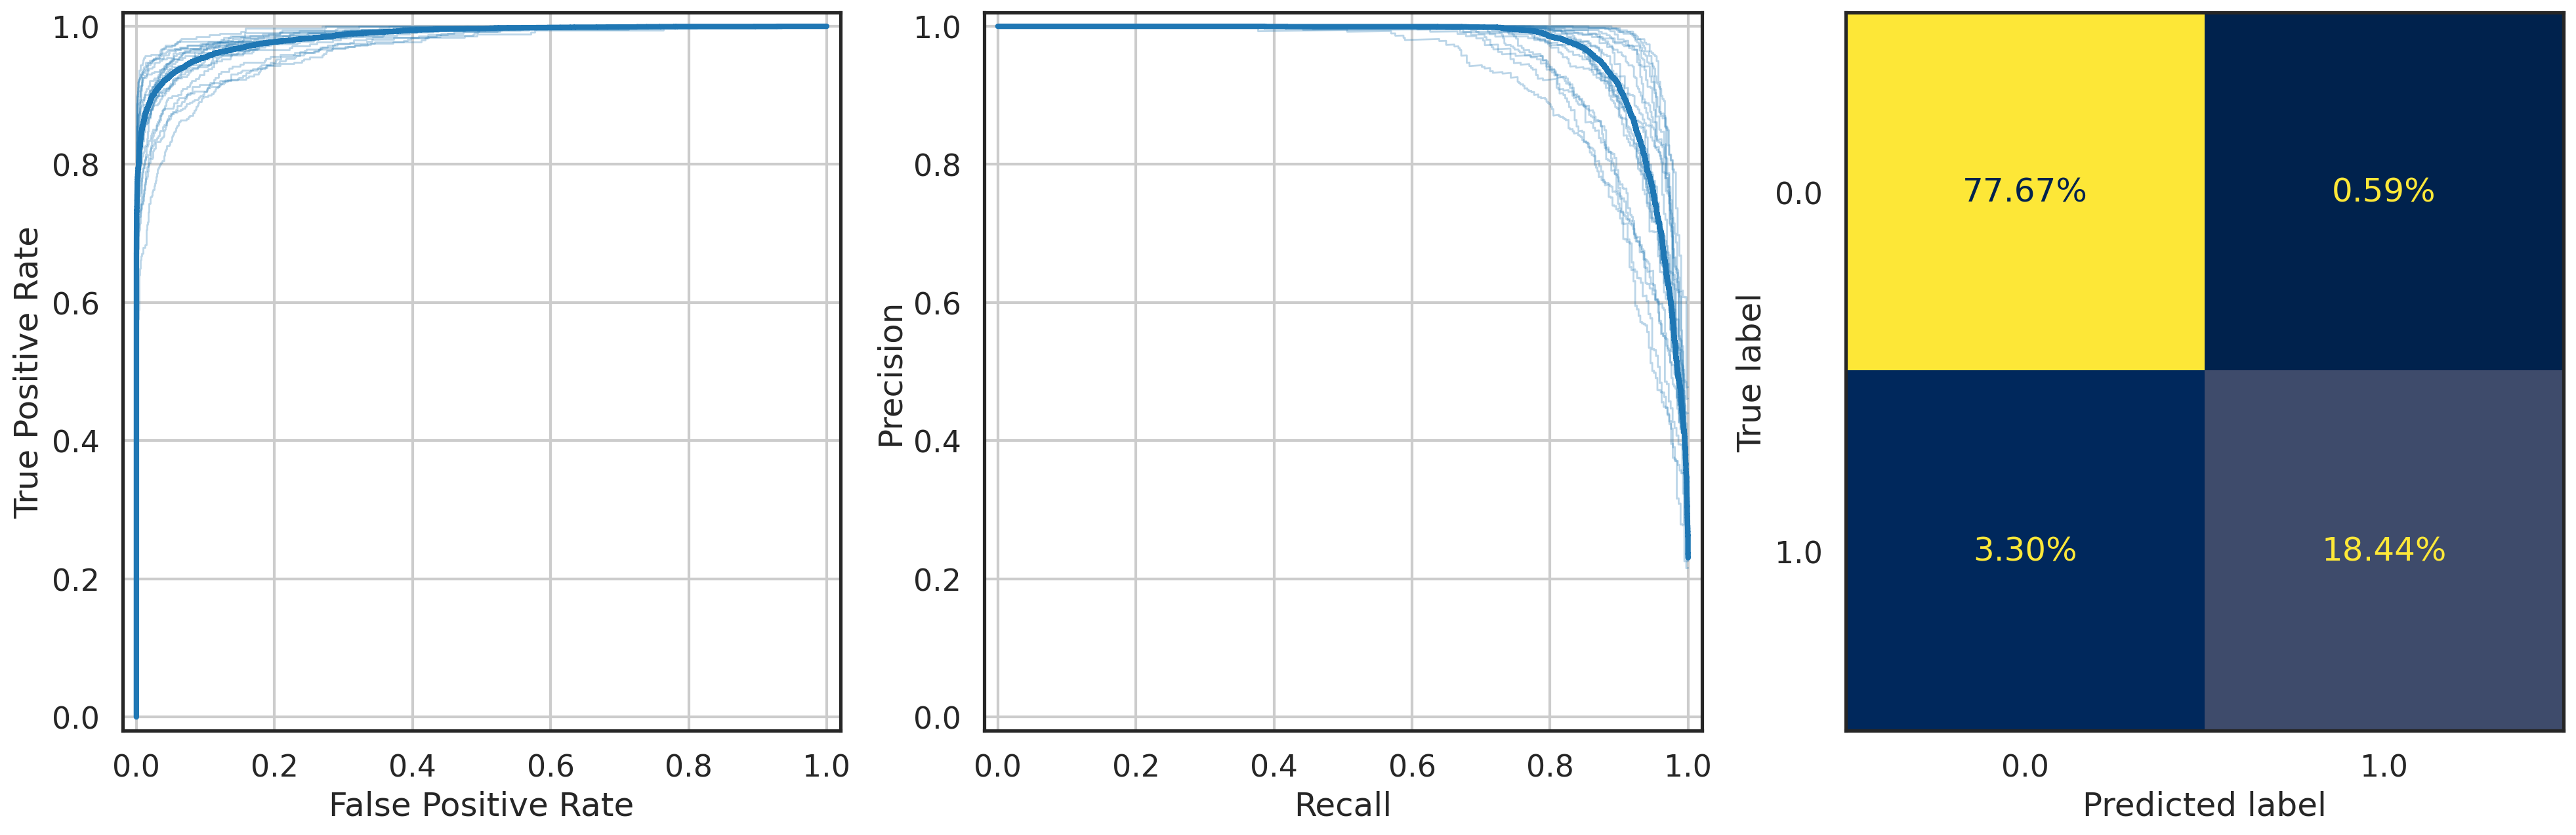

In [8]:
# base = 'local/out/exp/' + ts
# mkdirp(base)
# print(base)

# T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))
# test_history.to_csv(base+'/test.csv', index=False)
# test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
# test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [9]:
import random

In [24]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [41]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []
losses_reflexivity_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    reflexivity_subsumption = trained_reasoner.sub_nn(im(input1, input1))
    losses_reflexivity_subsumption.append(1 - T.sigmoid(reflexivity_subsumption).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item() )


In [39]:
T.set_printoptions(precision=4)

In [40]:
losses_bot_concept_self =[]
for i in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item() )

print(np.mean(losses_bot_concept_self))
print(np.std(losses_bot_concept_self))

1.643860340118408e-05
1.0473438355290117e-05


In [42]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Reflexivity of Subsumption", losses_reflexivity_subsumption, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.269103
  Std Dev Loss: 0.030472
  Mean Diff: 0.549324
  Std Dev Diff: 0.095086

Duality of Top and Bottom:
  Mean Loss: 0.379637
  Std Dev Loss: 0.000000
  Mean Diff: 0.702399
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.127786
  Std Dev Loss: 0.032666
  Mean Diff: 0.318663
  Std Dev Diff: 0.090167

Associativity:
  Mean Loss: 0.036030
  Std Dev Loss: 0.011585
  Mean Diff: 0.081500
  Std Dev Diff: 0.025926

Commutativity:
  Mean Loss: 0.037055
  Std Dev Loss: 0.012885
  Mean Diff: 0.087840
  Std Dev Diff: 0.031961

Contradiction:
  Mean Loss: 0.377346
  Std Dev Loss: 0.022834
  Mean Diff: 0.818015
  Std Dev Diff: 0.068375

Identity with Top:
  Mean Loss: 0.153825
  Std Dev Loss: 0.038625
  Mean Diff: 0.372410
  Std Dev Diff: 0.109185

Absorption by Bottom:
  Mean Loss: 0.376674
  Std Dev Loss: 0.018878
  Mean Diff: 0.731397
  Std Dev Diff: 0.029096

Top Concept Subsumption:
  Mean Loss: 0.000503
  Std Dev Loss: 0.000439
  Mean Diff: N/A
  Std De

In [26]:
losses = []
diffs = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )
    diffs.append(max_element_difference(input, trained_reasoner.and_nn(im(input, input))))

print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))
print(np.std(losses))
print()
print(np.mean(diffs))
print(np.std(diffs))

tensor([-0.0940,  0.1887, -0.1290,  0.0188,  0.3290, -0.1771,  0.0791,  0.0959,
        -0.0058, -0.0246], grad_fn=<SelectBackward0>)
tensor([ 0.1576,  0.1885, -0.1997,  0.1270, -0.0011,  0.1951,  0.0659,  0.1380,
        -0.1702, -0.1773], grad_fn=<AddBackward0>)
0.12652871676534413
0.030663503603145466
0.3158855241239071
0.08832188243054465


In [11]:
losses = []
diffs = []

for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
    diffs.append(max_element_difference(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]))

print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))
print(np.std(losses))
print()
print(np.mean(diffs))
print(np.std(diffs))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([-0.5723, -0.3951,  0.4263,  0.0557,  0.2185,  0.2075,  0.2419, -0.3870,
         0.5748,  0.3754], grad_fn=<AddBackward0>)
0.39313528886437415


In [12]:
losses = []
diffs = []

for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))
print(np.std(losses))
print()
print(np.mean(diffs))
print(np.std(diffs))

tensor([ 0.0901, -0.1024, -0.1872, -0.0177, -0.0107,  0.0207, -0.1027,  0.0847,
         0.0223, -0.2291], grad_fn=<SelectBackward0>)
tensor([ 0.1134,  0.2131, -0.1626,  0.0914, -0.0062,  0.2889, -0.1709, -0.0243,
        -0.0409, -0.0574], grad_fn=<AddBackward0>)
0.1631902848780155


In [13]:
losses = []
for _ in range(1000):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([ 0.0916,  0.0622, -0.0311,  0.1425, -0.0050,  0.2525,  0.1607,  0.0822,
         0.0079, -0.1501], grad_fn=<AddBackward0>)
0.37772091493010523


In [14]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([-0.3034, -0.4222,  0.6476,  0.4729, -0.6379,  0.5930, -0.4687,  0.0676,
        -0.0402,  0.0658], grad_fn=<SelectBackward0>)
tensor([ 0.0229,  0.2007,  0.7249,  0.5370, -0.0215,  0.0441, -0.1353,  0.2239,
         0.6622, -0.2826], grad_fn=<AddBackward0>)
tensor(0.3796, grad_fn=<L1LossBackward0>)


In [15]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([ 0.1090,  0.0754,  0.2614, -0.0397,  0.2937, -0.8621, -0.9519,  0.7124,
        -0.1034, -0.0492], grad_fn=<SelectBackward0>)
tensor([ 0.5670,  0.6208, -0.4071,  0.1943,  0.0985, -0.4068, -0.7802,  0.8731,
        -0.7390, -0.5552], grad_fn=<AddBackward0>)
tensor(0.4030, grad_fn=<L1LossBackward0>)


In [16]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([-0.0176, -0.0918, -0.0038,  0.1173,  0.0116,  0.2594,  0.1851, -0.0657,
         0.0668,  0.0278], grad_fn=<AddBackward0>)
tensor([-0.0949, -0.1006,  0.0425,  0.1610,  0.0495,  0.2176,  0.1477, -0.0771,
         0.0998,  0.0238], grad_fn=<AddBackward0>)
0.03546390381734818


In [17]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.0275,  0.0365, -0.0788,  0.0994, -0.0183,  0.1809,  0.0612,  0.0718,
        -0.0494, -0.0682], grad_fn=<AddBackward0>)
tensor([ 0.0633,  0.0649, -0.1142,  0.1583,  0.0572,  0.2013,  0.1241,  0.0055,
        -0.0561, -0.0782], grad_fn=<AddBackward0>)
0.03695034835394472


In [18]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([ 0.0724, -0.1768, -0.1841, -0.0886,  0.2182, -0.1939,  0.1098, -0.0832,
        -0.0839, -0.2873], grad_fn=<SelectBackward0>)
tensor([ 0.1273,  0.2673, -0.2041,  0.2311,  0.1780,  0.1154,  0.0210,  0.2299,
        -0.3037, -0.2423], grad_fn=<AddBackward0>)
0.15397981809452177


In [19]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9994667763710022


In [20]:
losses = []
for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

0.999992847442627
